In [1]:
# 0. Imports
import os
import math
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import clone
import joblib

# Optional libraries that may not be installed in all environments
try:
    from feature_engine.outliers import Winsorizer
except Exception:
    Winsorizer = None

# Try to import LightGBM / CatBoost / XGBoost in order of preference
TREE_MODEL = None
try:
    import lightgbm as lgb
    TREE_MODEL = 'lightgbm'
except Exception:
    try:
        import catboost as cb
        TREE_MODEL = 'catboost'
    except Exception:
        try:
            import xgboost as xgb
            TREE_MODEL = 'xgboost'
        except Exception:
            TREE_MODEL = None

try:
    import shap
    SHAP_AVAILABLE = True
except Exception:
    SHAP_AVAILABLE = False


# 1. Do a descriptive analysis of all the variables.

In [2]:
df=pd.read_csv(r"D:\python\Moxietek codes\TrainingData.csv")
df.head()

,Id,city,age,sex,social_class,primary_business,secondary_business,annual_income,monthly_expenses,old_dependents,young_dependents,home_ownership,type_of_house,occupants_count,house_area,sanitary_availability,water_availabity,loan_purpose,loan_tenure,loan_installments,loan_amount
0,1,Dhanbad,22,F,Mochi,Tailoring,Others,36000.0,5000.0,0,2,1.0,R,4,70.0,1.0,0.5,Apparels,12,12,5000.0
1,2,Manjapra,21,F,OBC,Tailoring,none,94000.0,3600.0,1,1,1.0,T1,4,80.0,1.0,0.5,Apparels,12,50,7500.0
2,3,Dhanbad,24,M,Nai,Beauty salon,Others,48000.0,4000.0,0,2,1.0,T1,4,50.0,1.0,0.5,Beauty Salon,12,12,5000.0
3,4,NaN,26,F,OBC,Tailoring,none,7000.0,5000.0,0,2,1.0,T1,5,50.0,1.0,0.5,Apparels,12,50,7500.0
4,5,Nuapada,23,F,OBC,General store,Agriculture,36000.0,3500.0,0,0,1.0,T1,1,112.0,1.0,0.5,Retail Store,12,12,5000.0


In [3]:
def get_data_report(df):
    """Provides a comprehensive overview of a DataFrame."""
    print("\n\033[1mShape of DataFrame:\033[0m ", df.shape)
    print("\n\033[1mColumns in DataFrame:\033[0m ", df.columns.to_list())
    print("\n\033[1mInformation about DataFrame:\033[0m")
    df.info()
    print("\n\033[1mUnique values per column:\033[0m")
    print(df.nunique())
    print("\n\033[1mNull values:\033[0m\n", df.isnull().sum())
    print("\n\033[1mDuplicate rows:\033[0m ", df.duplicated().sum())
    print("\n\033[1mDescriptive statistics:\033[0m\n", df.describe().transpose())


In [4]:
get_data_report(df)


Shape of DataFrame:  (40000, 21)

Columns in DataFrame:  ['Id', 'city', 'age', 'sex', 'social_class', 'primary_business', 'secondary_business', 'annual_income', 'monthly_expenses', 'old_dependents', 'young_dependents', 'home_ownership', 'type_of_house', 'occupants_count', 'house_area', 'sanitary_availability', 'water_availabity', 'loan_purpose', 'loan_tenure', 'loan_installments', 'loan_amount']

Information about DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id                     40000 non-null  int64  
 1   city                   38136 non-null  object 
 2   age                    40000 non-null  int64  
 3   sex                    40000 non-null  object 
 4   social_class           34745 non-null  object 
 5   primary_business       39974 non-null  object 
 6   secondary_business     34759 non-null  o

In [5]:
#Calculating missing value in percentage
(df.isnull().sum()/40000)*100

Id                        0.0000
city                      4.6600
age                       0.0000
sex                       0.0000
social_class             13.1375
primary_business          0.0650
secondary_business       13.1025
annual_income             0.0000
monthly_expenses          0.3000
old_dependents            0.0000
young_dependents          0.0000
home_ownership            0.9475
type_of_house             1.7350
occupants_count           0.0000
house_area                0.0000
sanitary_availability     0.5200
water_availabity         13.1325
loan_purpose              0.0650
loan_tenure               0.0000
loan_installments         0.0000
loan_amount               0.0000
dtype: float64

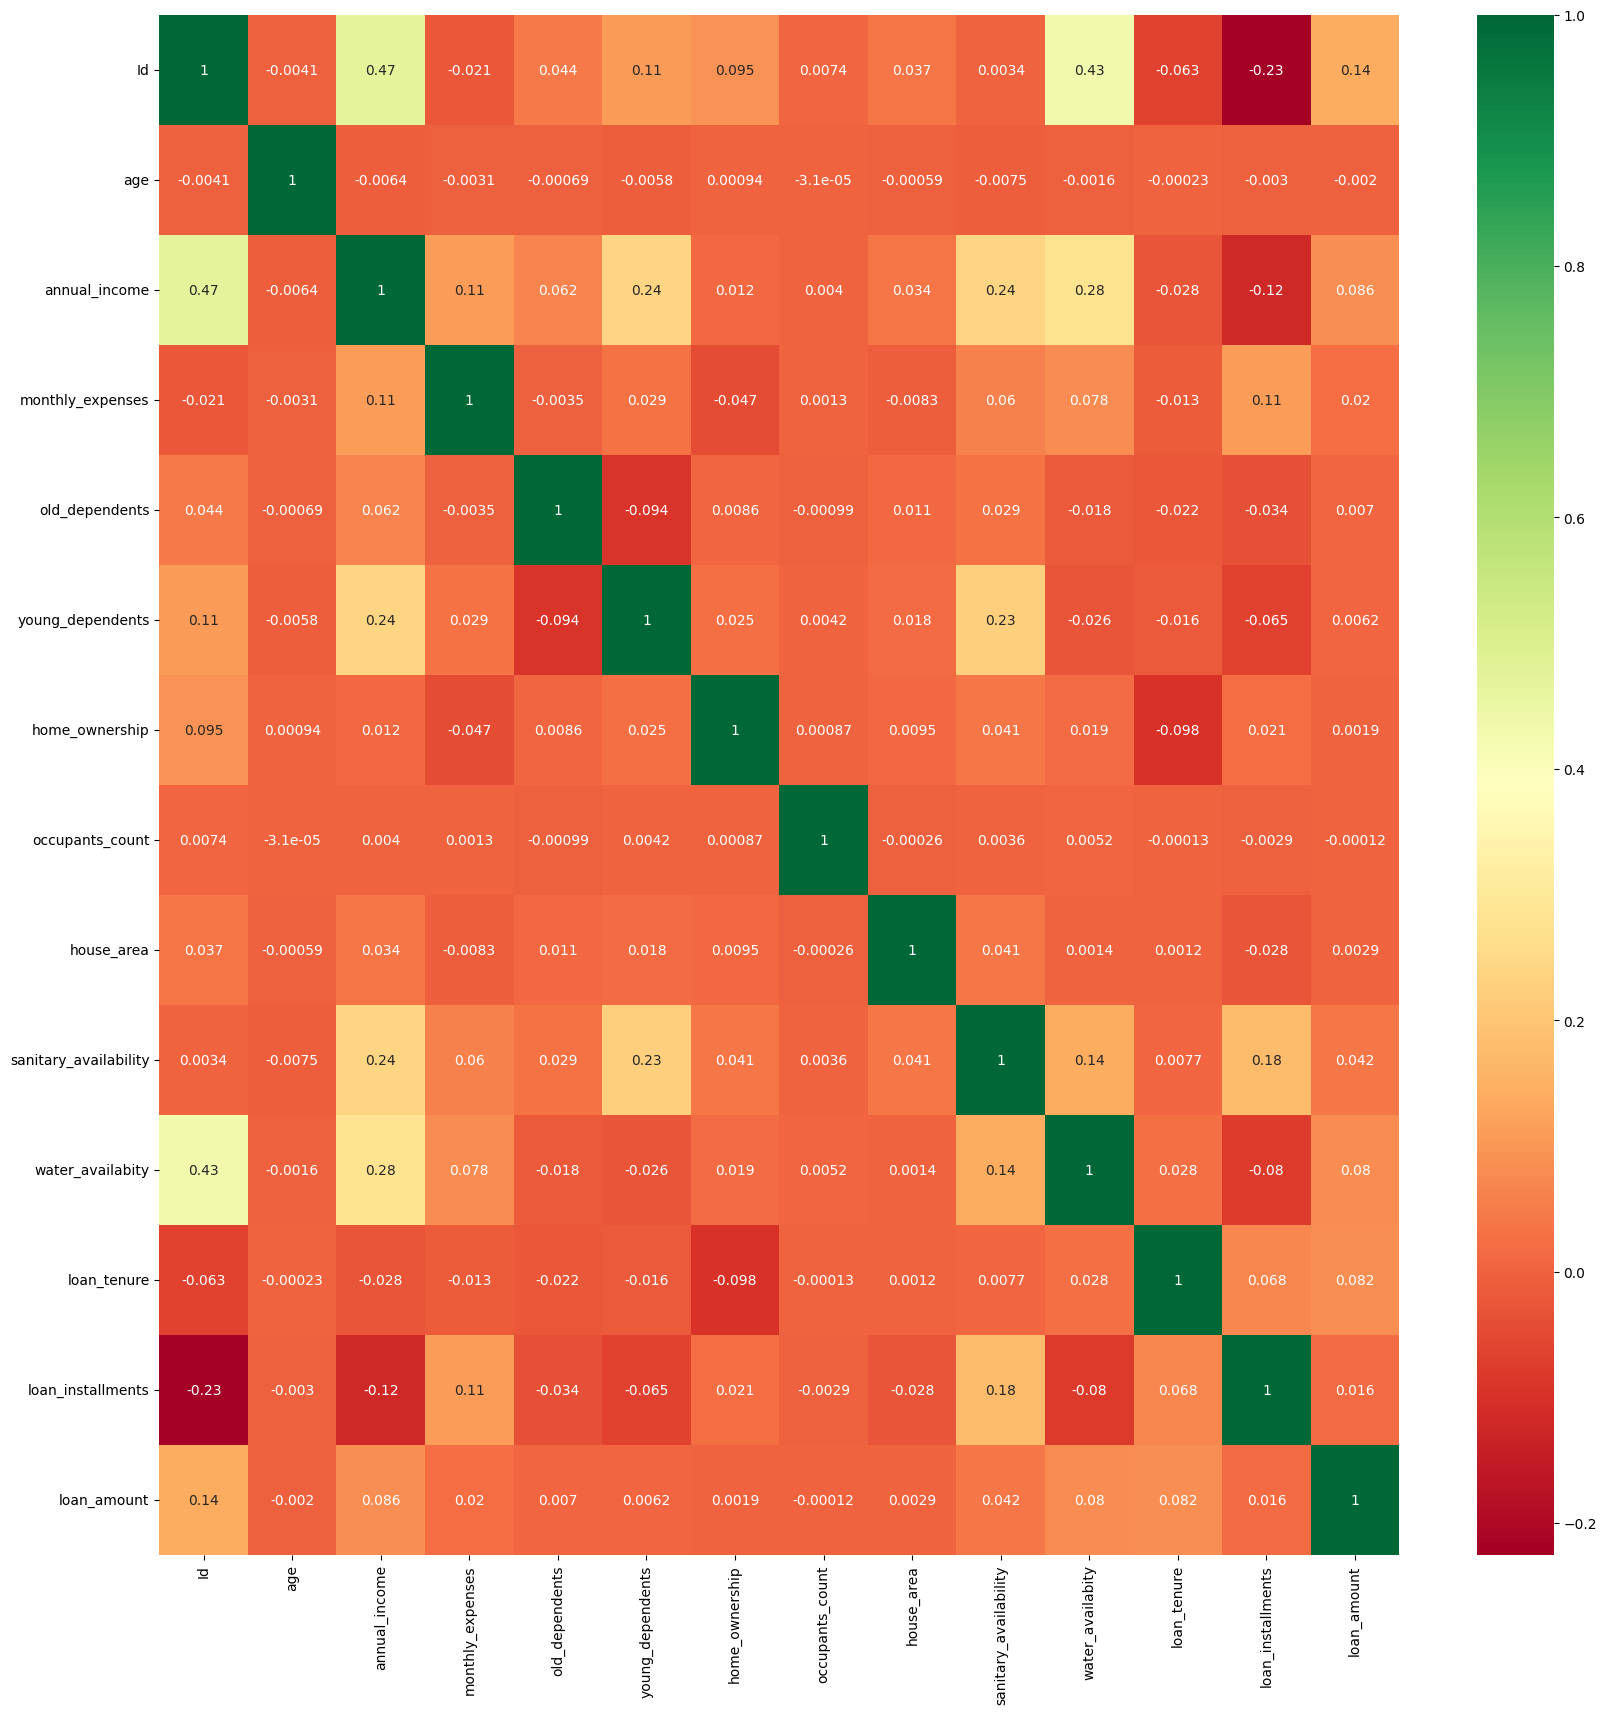

In [6]:
# Get correlations of each features in dataset
import matplotlib.pyplot as plt
import seaborn as sns

corrmat = df.select_dtypes(include=np.number).corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# 2. Exploratory Data Analysis

In [7]:
# Personal Details: city, age, sex, social_class
personal_data=pd.DataFrame(df,columns=["city","age","sex","social_class"])
personal_data.head()

,city,age,sex,social_class
0,Dhanbad,22,F,Mochi
1,Manjapra,21,F,OBC
2,Dhanbad,24,M,Nai
3,NaN,26,F,OBC
4,Nuapada,23,F,OBC


In [8]:
get_data_report(personal_data)


Shape of DataFrame:  (40000, 4)

Columns in DataFrame:  ['city', 'age', 'sex', 'social_class']

Information about DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   city          38136 non-null  object
 1   age           40000 non-null  int64 
 2   sex           40000 non-null  object
 3   social_class  34745 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.2+ MB

Unique values per column:
city            856
age              62
sex               3
social_class    519
dtype: int64

Null values:
 city            1864
age                0
sex                0
social_class    5255
dtype: int64

Duplicate rows:  25970

Descriptive statistics:
        count     mean         std  min   25%   50%   75%       max
age  40000.0  55.1599  3830.35566  2.0  29.0  35.0  42.0  766105.0


In [9]:
# Value counts for categorical features
print("Value counts for 'city':")
print(personal_data['city'].value_counts().head()) # Displaying head due to large number of unique cities
print("\nValue counts for 'sex':")
print(personal_data['sex'].value_counts())
print("\nValue counts for 'social_class':")
print(personal_data['social_class'].value_counts().head()) # Displaying head due to large number of unique social classes

Value counts for 'city':
city
Pusad         3154
Bahoriband    1979
PUSAD         1776
Shantipur     1727
Imphal        1699
Name: count, dtype: int64

Value counts for 'sex':
sex
F     37622
M      2371
TG        7
Name: count, dtype: int64

Value counts for 'social_class':
social_class
OBC        10683
SC          3136
ST          2616
General     2299
Muslim      1743
Name: count, dtype: int64


In [10]:
# Descriptive statistics for 'age'
print("Descriptive statistics for 'age':")
print(personal_data['age'].describe())



Descriptive statistics for 'age':
count     40000.00000
mean         55.15990
std        3830.35566
min           2.00000
25%          29.00000
50%          35.00000
75%          42.00000
max      766105.00000
Name: age, dtype: float64



Value counts and distribution for 'sex':
sex
F     37622
M      2371
TG        7
Name: count, dtype: int64


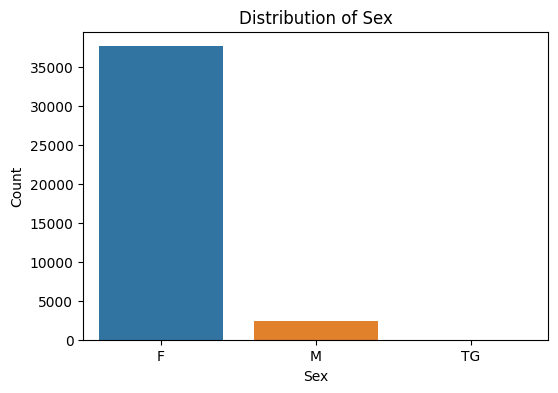


Value counts and distribution for 'social_class':
social_class
OBC               10683
SC                 3136
ST                 2616
General            2299
Muslim             1743
S.C                 950
Minority            892
Hindu               869
GC                  807
Sechudle Caste      769
Name: count, dtype: int64


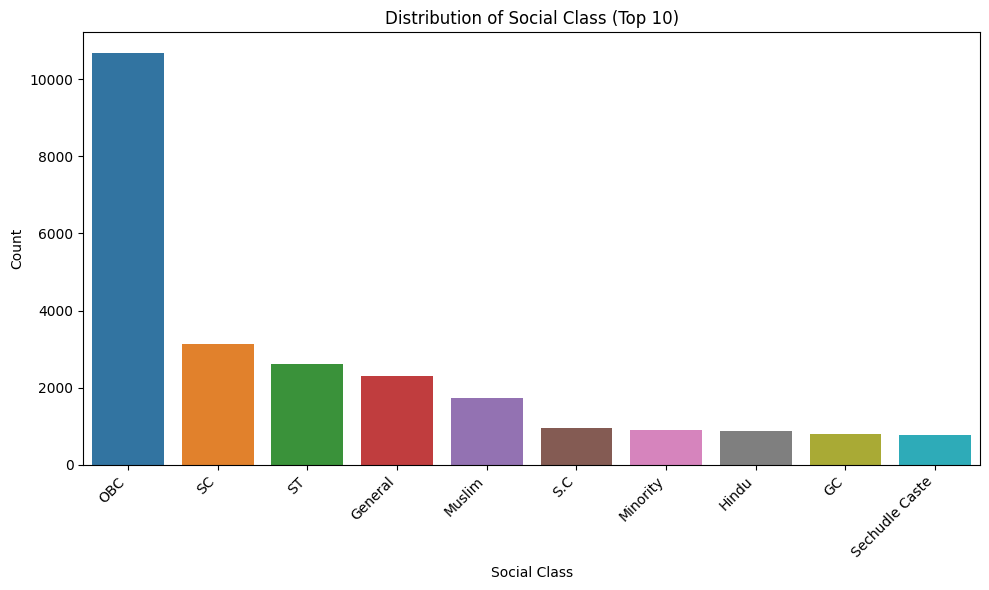

In [11]:
# Value counts and visualizations for 'sex'
print("\nValue counts and distribution for 'sex':")
print(personal_data['sex'].value_counts())
plt.figure(figsize=(6, 4))
sns.countplot(data=personal_data, x='sex', order=personal_data['sex'].value_counts().index)
plt.title('Distribution of Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

# Value counts and visualizations for 'social_class'
print("\nValue counts and distribution for 'social_class':")
print(personal_data['social_class'].value_counts().head(10)) # Displaying top 10 due to many unique values
plt.figure(figsize=(10, 6))
sns.countplot(data=personal_data, x='social_class', order=personal_data['social_class'].value_counts().head(10).index)
plt.title('Distribution of Social Class (Top 10)')
plt.xlabel('Social Class')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 2. Financial Details

In [12]:
#Financial Details: primary_business, secondary_business, annual_income, monthly_expenses,
#old_dependents, young_dependents
financial_details_data=pd.DataFrame(df,columns=["primary_business","secondary_business","annual_income","monthly_expenses",
                                                 "old_dependents","young_dependents"])
financial_details_data.head()

,primary_business,secondary_business,annual_income,monthly_expenses,old_dependents,young_dependents
0,Tailoring,Others,36000.0,5000.0,0,2
1,Tailoring,none,94000.0,3600.0,1,1
2,Beauty salon,Others,48000.0,4000.0,0,2
3,Tailoring,none,7000.0,5000.0,0,2
4,General store,Agriculture,36000.0,3500.0,0,0


In [13]:
get_data_report(financial_details_data)


Shape of DataFrame:  (40000, 6)

Columns in DataFrame:  ['primary_business', 'secondary_business', 'annual_income', 'monthly_expenses', 'old_dependents', 'young_dependents']

Information about DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   primary_business    39974 non-null  object 
 1   secondary_business  34759 non-null  object 
 2   annual_income       40000 non-null  float64
 3   monthly_expenses    39880 non-null  float64
 4   old_dependents      40000 non-null  int64  
 5   young_dependents    40000 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 1.8+ MB

Unique values per column:
primary_business      441
secondary_business      5
annual_income         359
monthly_expenses      260
old_dependents          4
young_dependents        8
dtype: int64

Null values:
 primary_business      

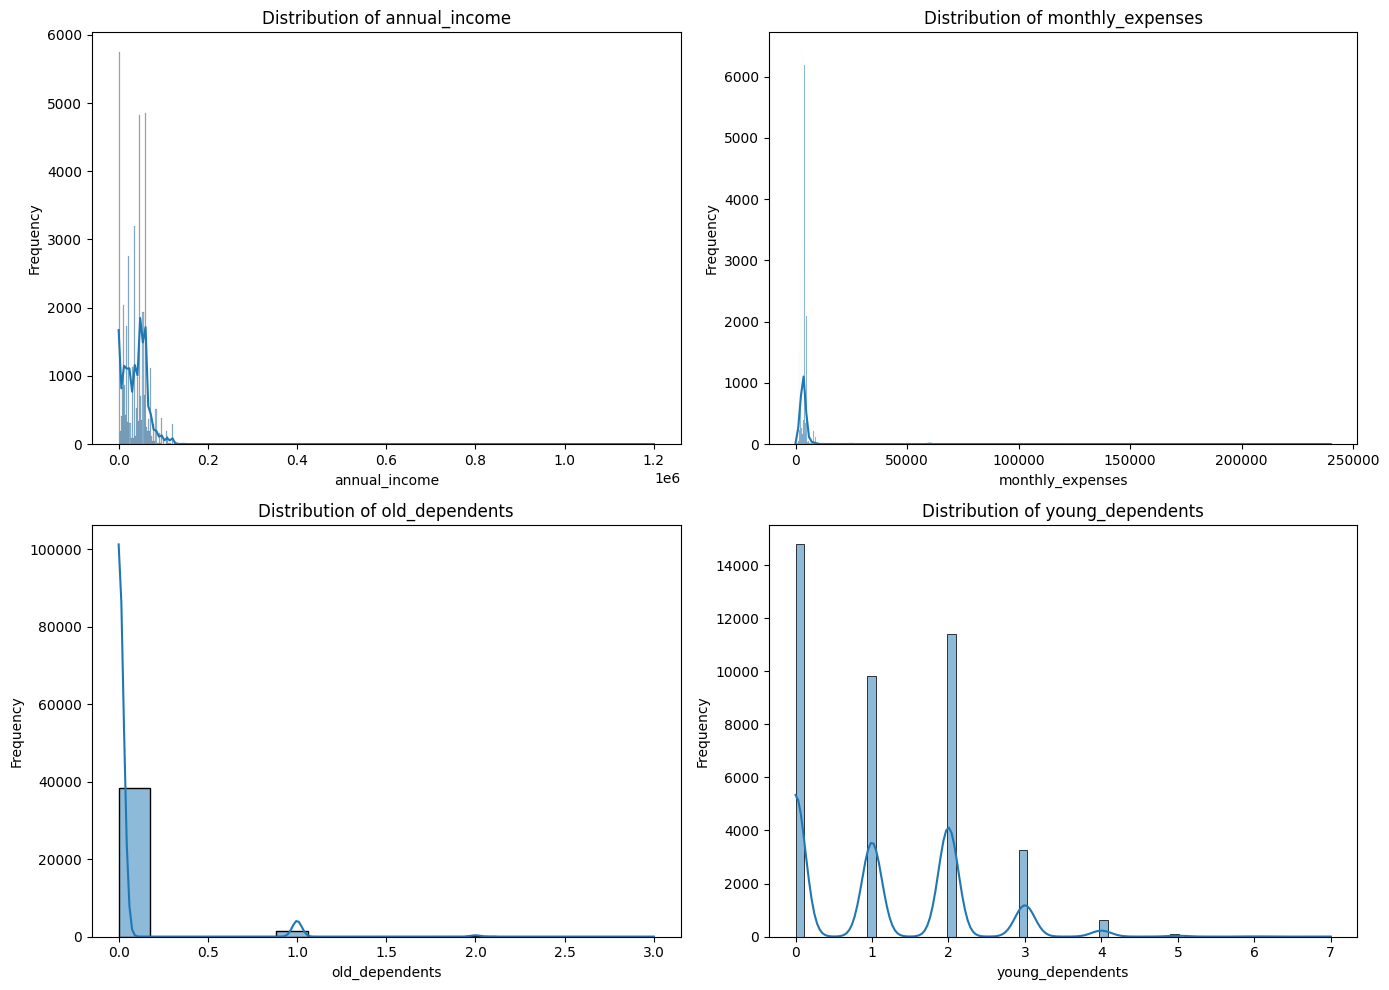

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()

financial_cols = ['annual_income', 'monthly_expenses', 'old_dependents', 'young_dependents']

for i, col in enumerate(financial_cols):
    sns.histplot(financial_details_data[col].dropna(), kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

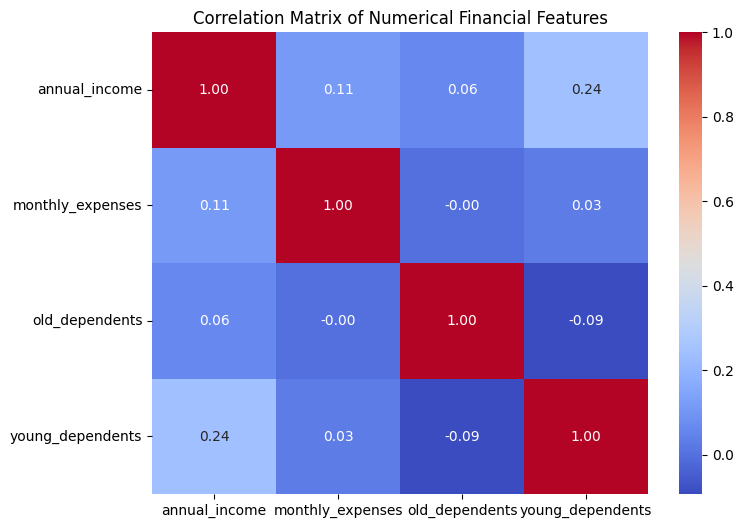

In [15]:
# Select the numerical financial features
numerical_financial_cols = ['annual_income', 'monthly_expenses', 'old_dependents', 'young_dependents']
financial_numerical_data = financial_details_data[numerical_financial_cols]

# Generate the correlation matrix
correlation_matrix = financial_numerical_data.corr()

# Display the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Financial Features')
plt.show()



Value counts for 'primary_business':
primary_business
Tailoring                3971
Goat rearing             2268
Cow Rearing              2077
Handloom Work            2068
Vegetable cultivation    1704
Grocery store            1369
School                   1332
Milk business            1310
Vegetable vendor         1174
Weaver                   1157
Name: count, dtype: int64


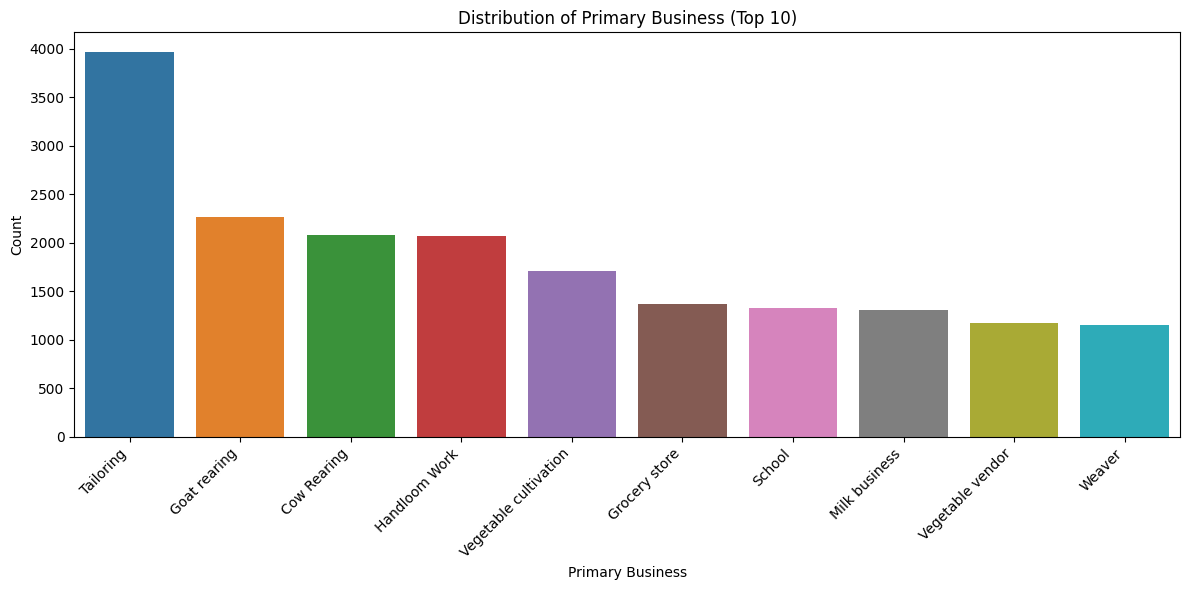


Value counts for 'secondary_business':
secondary_business
none                   27366
Others                  2564
Daily wage labourer     2545
Agriculture             2105
Livestock rearing        179
Name: count, dtype: int64


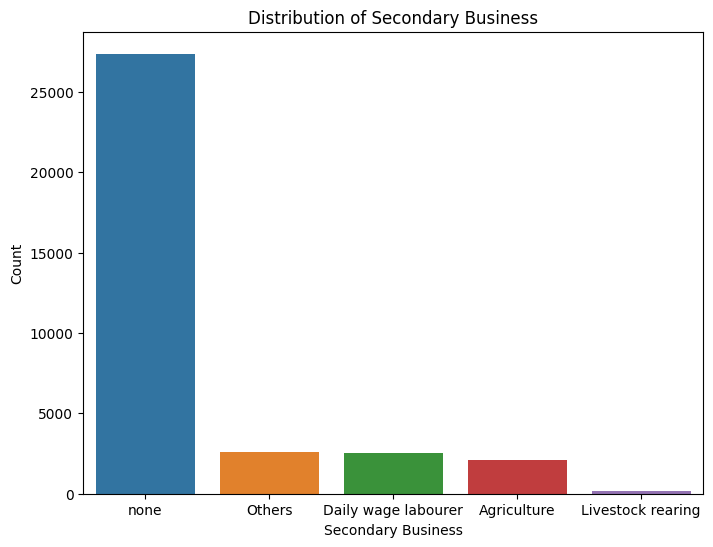

In [16]:
# Print value counts for 'primary_business' (top 10)
print("Value counts for 'primary_business':")
print(financial_details_data['primary_business'].value_counts().head(10))

# Create a bar plot for the top 10 'primary_business' categories
plt.figure(figsize=(12, 6))
sns.countplot(data=financial_details_data, x='primary_business', order=financial_details_data['primary_business'].value_counts().head(10).index)
plt.title('Distribution of Primary Business (Top 10)')
plt.xlabel('Primary Business')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print value counts for 'secondary_business'
print("\nValue counts for 'secondary_business':")
print(financial_details_data['secondary_business'].value_counts())

# Create a bar plot for 'secondary_business' categories
plt.figure(figsize=(8, 6))
sns.countplot(data=financial_details_data, x='secondary_business', order=financial_details_data['secondary_business'].value_counts().index)
plt.title('Distribution of Secondary Business')
plt.xlabel('Secondary Business')
plt.ylabel('Count')
plt.show()

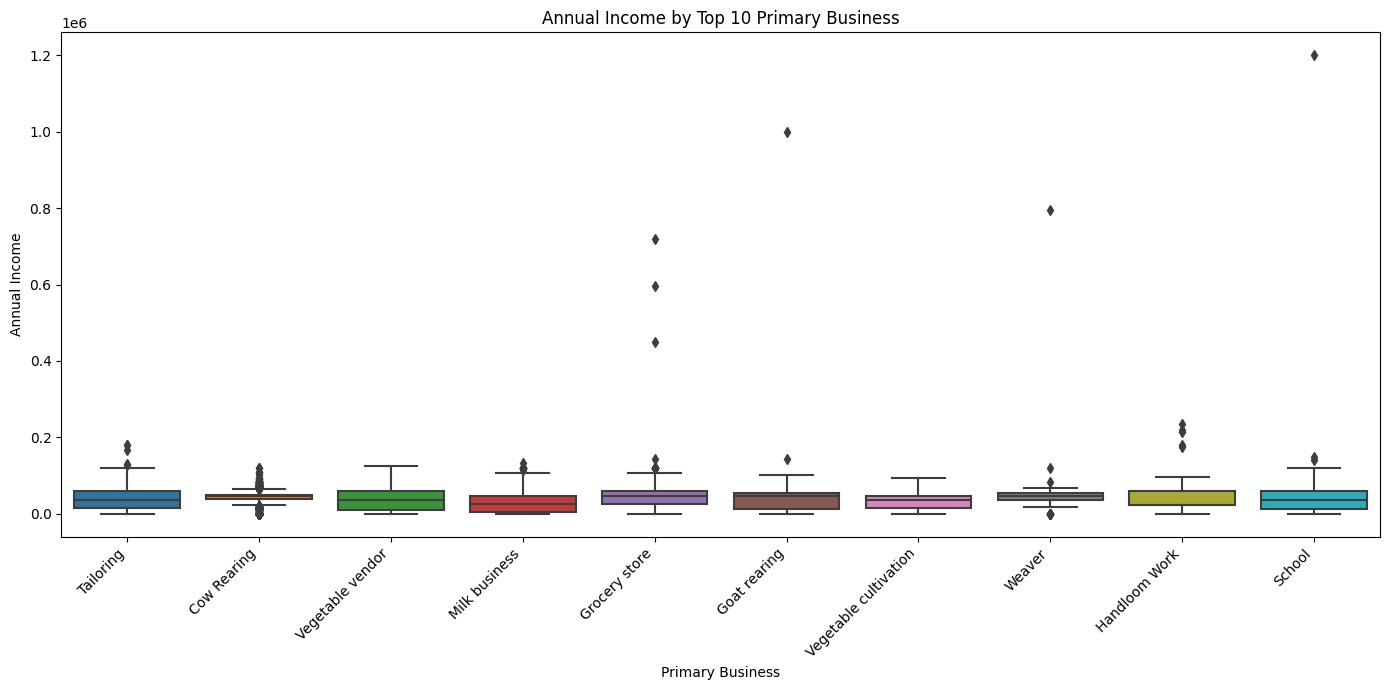

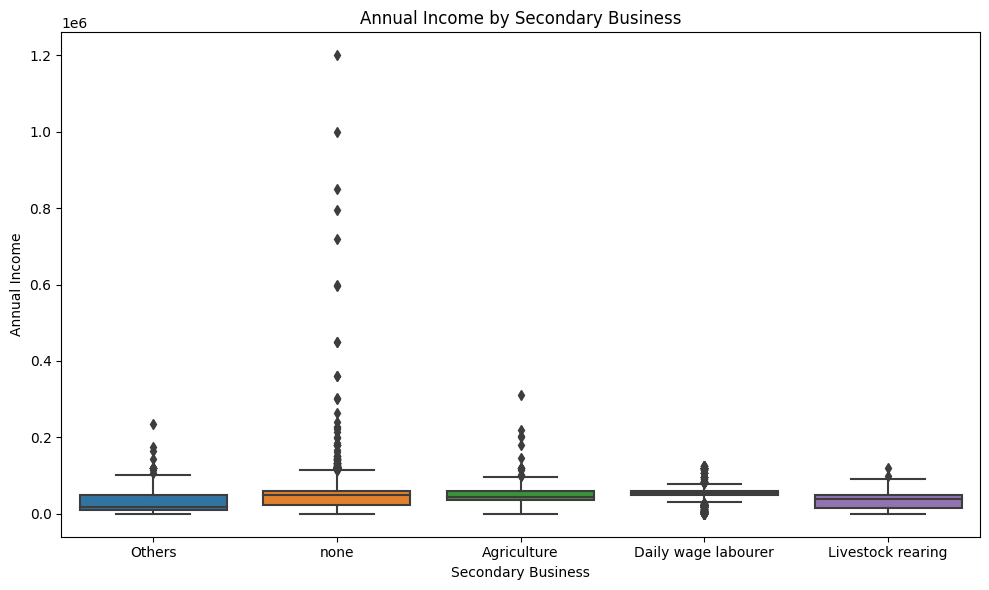

In [17]:
# Get the top 10 primary businesses
top_10_primary_business = financial_details_data['primary_business'].value_counts().head(10).index.tolist()
financial_details_top_10_primary = financial_details_data[financial_details_data['primary_business'].isin(top_10_primary_business)]

# 1. Box plot: primary_business (top 10) vs annual_income
plt.figure(figsize=(14, 7))
sns.boxplot(data=financial_details_top_10_primary, x='primary_business', y='annual_income')
plt.title('Annual Income by Top 10 Primary Business')
plt.xlabel('Primary Business')
plt.ylabel('Annual Income')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 2. Box plot: secondary_business vs annual_income
plt.figure(figsize=(10, 6))
sns.boxplot(data=financial_details_data, x='secondary_business', y='annual_income')
plt.title('Annual Income by Secondary Business')
plt.xlabel('Secondary Business')
plt.ylabel('Annual Income')
plt.tight_layout()
plt.show()


# 3.House Details

In [18]:
#House Details: home_ownership, type_of_house, occupants_count, house_area, sanitary_availability,
#water_availability
house_details_data=pd.DataFrame(df,columns=["home_ownership","type_of_house","occupants_count",
                                             "house_area","sanitary_availability","water_availabity"])
house_details_data.head(5)

,home_ownership,type_of_house,occupants_count,house_area,sanitary_availability,water_availabity
0,1.0,R,4,70.0,1.0,0.5
1,1.0,T1,4,80.0,1.0,0.5
2,1.0,T1,4,50.0,1.0,0.5
3,1.0,T1,5,50.0,1.0,0.5
4,1.0,T1,1,112.0,1.0,0.5


In [19]:
get_data_report(house_details_data)


Shape of DataFrame:  (40000, 6)

Columns in DataFrame:  ['home_ownership', 'type_of_house', 'occupants_count', 'house_area', 'sanitary_availability', 'water_availabity']

Information about DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   home_ownership         39621 non-null  float64
 1   type_of_house          39306 non-null  object 
 2   occupants_count        40000 non-null  int64  
 3   house_area             40000 non-null  float64
 4   sanitary_availability  39792 non-null  float64
 5   water_availabity       34747 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 1.8+ MB

Unique values per column:
home_ownership             2
type_of_house              3
occupants_count           23
house_area               391
sanitary_availability      3
water_availabity           4
dtype: int64

Value counts for 'home_ownership':
home_ownership
1.0    38531
0.0     1090
Name: count, dtype: int64


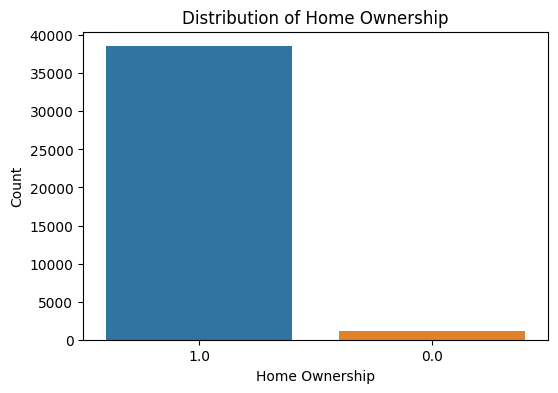


Value counts for 'type_of_house':
type_of_house
T2    17715
T1    15092
R      6499
Name: count, dtype: int64


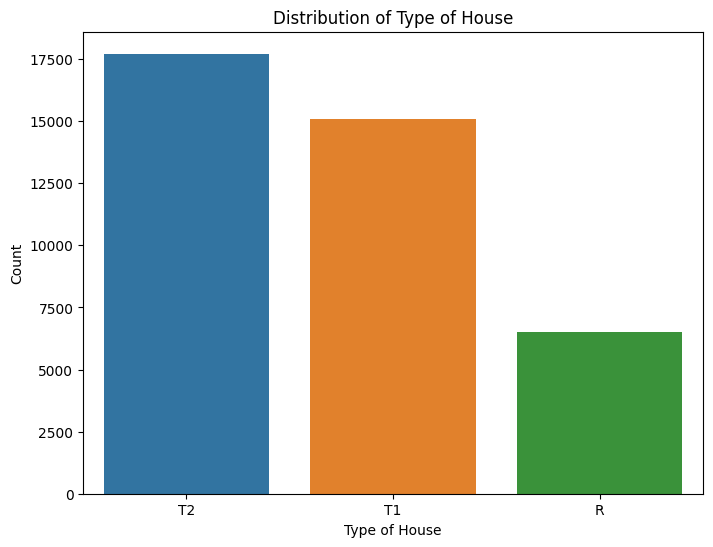

In [20]:
# Print the value counts for 'home_ownership'
print("Value counts for 'home_ownership':")
print(house_details_data['home_ownership'].value_counts())

# Create a bar plot for the distribution of 'home_ownership'
plt.figure(figsize=(6, 4))
sns.countplot(data=house_details_data, x='home_ownership', order=house_details_data['home_ownership'].value_counts().index)
plt.title('Distribution of Home Ownership')
plt.xlabel('Home Ownership')
plt.ylabel('Count')
plt.show()

# Print the value counts for 'type_of_house'
print("\nValue counts for 'type_of_house':")
print(house_details_data['type_of_house'].value_counts())

# Create a bar plot for the distribution of 'type_of_house'
plt.figure(figsize=(8, 6))
sns.countplot(data=house_details_data, x='type_of_house', order=house_details_data['type_of_house'].value_counts().index)
plt.title('Distribution of Type of House')
plt.xlabel('Type of House')
plt.ylabel('Count')
plt.show()

# 4.Loan Details:

In [21]:
#Loan Details: loan_purpose, loan_tenure, loan_installments, loan_amount
#(these contain loan details of loans that have been previously given, and which have been repaid)

loan_details_data=pd.DataFrame(df,columns=["loan_purpose","loan_tenure","loan_installments","loan_amount"])
loan_details_data.head()

,loan_purpose,loan_tenure,loan_installments,loan_amount
0,Apparels,12,12,5000.0
1,Apparels,12,50,7500.0
2,Beauty Salon,12,12,5000.0
3,Apparels,12,50,7500.0
4,Retail Store,12,12,5000.0


In [22]:
get_data_report(loan_details_data)


Shape of DataFrame:  (40000, 4)

Columns in DataFrame:  ['loan_purpose', 'loan_tenure', 'loan_installments', 'loan_amount']

Information about DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   loan_purpose       39974 non-null  object 
 1   loan_tenure        40000 non-null  int64  
 2   loan_installments  40000 non-null  int64  
 3   loan_amount        40000 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 1.2+ MB

Unique values per column:
loan_purpose          37
loan_tenure           11
loan_installments     21
loan_amount          115
dtype: int64

Null values:
 loan_purpose         26
loan_tenure           0
loan_installments     0
loan_amount           0
dtype: int64

Duplicate rows:  39267

Descriptive statistics:
                      count         mean           std    min     25%     

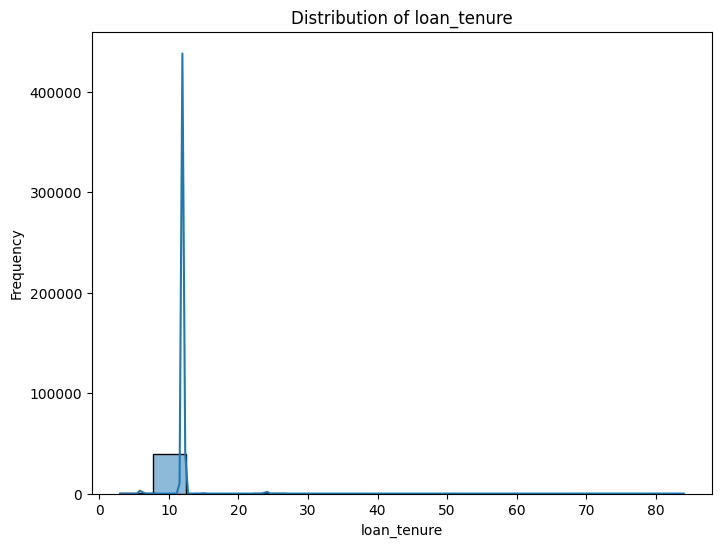

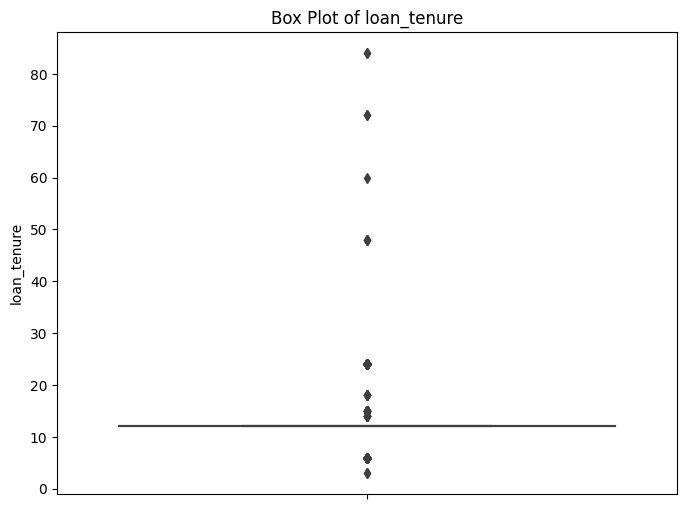

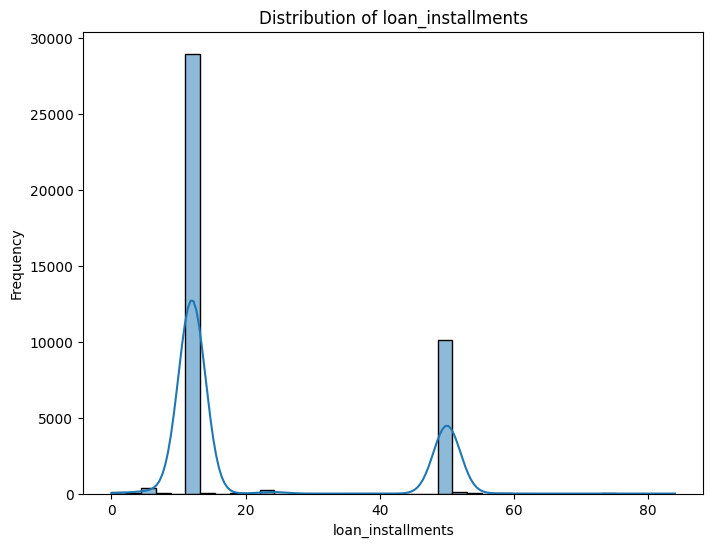

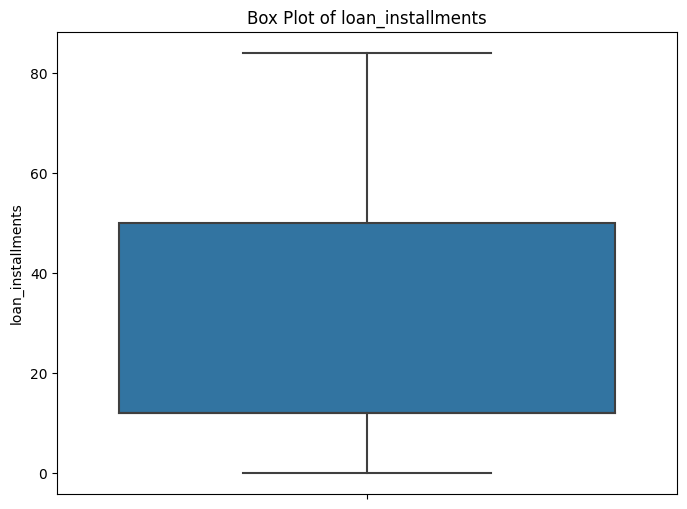

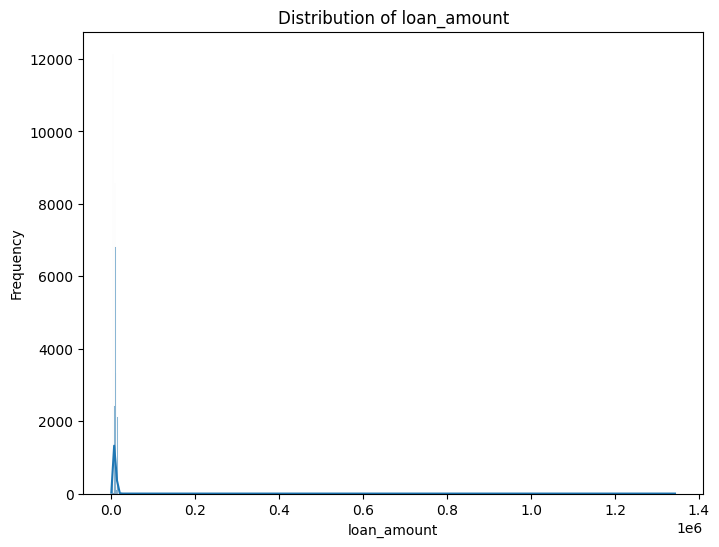

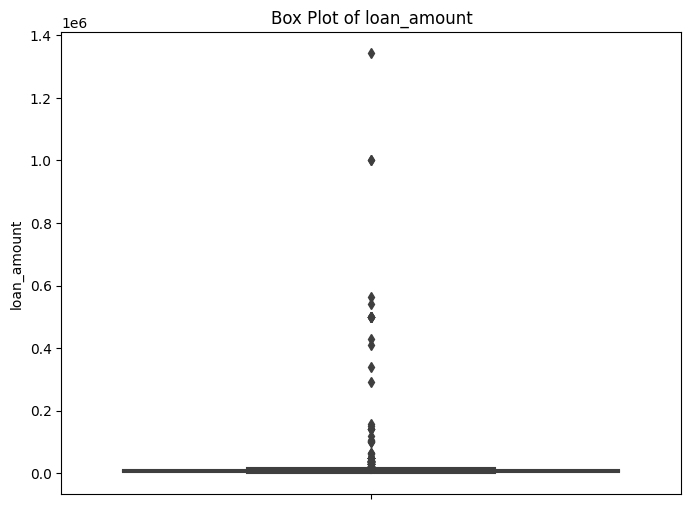

In [23]:

loan_details_data=pd.DataFrame(df,columns=["loan_purpose","loan_tenure","loan_installments","loan_amount"])
loan_details_data.head()

# 1. Create a list of the numerical columns related to loan details
numerical_loan_cols = ['loan_tenure', 'loan_installments', 'loan_amount']

# 2. Iterate through the list of numerical loan columns and create visualizations
for col in numerical_loan_cols:
    # 3. Create a histogram
    plt.figure(figsize=(8, 6))
    sns.histplot(data=loan_details_data, x=col, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

    # 4. Create a box plot
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=loan_details_data, y=col)
    plt.title(f'Box Plot of {col}')
    plt.ylabel(col)
    plt.show()

Strong predictors and feature reasoning

- annual_income — primary driver of loan capacity; highest expected predictive power.
- monthly_expenses — together with income defines available cashflow and repayment capacity.
- loan_tenure and loan_installments — structural loan terms correlated with loan_amount.
- age — proxy for earning potential, credit history stage, and repayment reliability.
- primary_business and secondary_business — business type captures earnings stability and sector risk.
- home_ownership, type_of_house, house_area, occupants_count — proxies for wealth, collateral, and socioeconomic   status.
- old_dependents and young_dependents — affect disposable income and risk.
- loan_purpose — purpose-specific limits or typical loan sizes.
- sex and city — may carry signal but must be handled carefully for fairness and regulatory constraints.

Feature engineering recommendations

- Create debt_capacity = annual_income - 12 * monthly_expenses and income_per_occupant = annual_income / max(1, occupants_count).

- Bucket rare categorical levels into "Other" for stable encoding.
- Winsorize or cap extreme annual_income, house_area, and occupants_count outliers before scaling.
- Create interaction features: income × home_ownership, loan_tenure × loan_installments.
- Convert loan_purpose to grouped categories (business, consumption, home improvements, education, medical, other).

In [24]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Load data
df.head()

# Feature creation
def add_features(X):
    X = X.copy()
    X["debt_capacity"] = X["annual_income"] - 12 * X["monthly_expenses"]
    X["income_per_occupant"] = X["annual_income"] / (X["occupants_count"].replace(0,1))
    X["income_to_expense_ratio"] = X["annual_income"] / (1 + 12 * X["monthly_expenses"])
    # bucket rare categories for primary_business and city
    for col in ["primary_business", "city", "loan_purpose", "social_class"]:
        if col in X.columns:
            top = X[col].value_counts().nlargest(50).index
            X[col] = np.where(X[col].isin(top), X[col], "Other")
    return X

featurizer = FunctionTransformer(add_features)

# Column lists
num_cols = ["age","annual_income","monthly_expenses","old_dependents","young_dependents",
            "occupants_count","house_area","loan_tenure","loan_installments",
            "debt_capacity","income_per_occupant","income_to_expense_ratio"]
cat_cols = ["sex","primary_business","secondary_business","home_ownership",
            "type_of_house","loan_purpose","city","social_class"]

# Preprocessing
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output==False))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

# Full pipeline placeholder for choice of model
def make_pipeline(model):
    return Pipeline([
        ("featurize", featurizer),
        ("preproc", preprocessor),
        ("model", model)
    ])

# Train test split
X = df.drop(columns=["loan_amount","Id"])
y = df["loan_amount"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


SyntaxError: positional argument follows keyword argument (3931717973.py, line 47)

In [33]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# Load data
df.head()


,Id,city,age,sex,social_class,primary_business,secondary_business,annual_income,monthly_expenses,old_dependents,young_dependents,home_ownership,type_of_house,occupants_count,house_area,sanitary_availability,water_availabity,loan_purpose,loan_tenure,loan_installments,loan_amount
0,1,Dhanbad,22,F,Mochi,Tailoring,Others,36000.0,5000.0,0,2,1.0,R,4,70.0,1.0,0.5,Apparels,12,12,5000.0
1,2,Manjapra,21,F,OBC,Tailoring,none,94000.0,3600.0,1,1,1.0,T1,4,80.0,1.0,0.5,Apparels,12,50,7500.0
2,3,Dhanbad,24,M,Nai,Beauty salon,Others,48000.0,4000.0,0,2,1.0,T1,4,50.0,1.0,0.5,Beauty Salon,12,12,5000.0
3,4,NaN,26,F,OBC,Tailoring,none,7000.0,5000.0,0,2,1.0,T1,5,50.0,1.0,0.5,Apparels,12,50,7500.0
4,5,Nuapada,23,F,OBC,General store,Agriculture,36000.0,3500.0,0,0,1.0,T1,1,112.0,1.0,0.5,Retail Store,12,12,5000.0


In [34]:
# Feature creation
def add_features(X):
    X = X.copy()
    X["debt_capacity"] = X["annual_income"] - 12 * X["monthly_expenses"]
    X["income_per_occupant"] = X["annual_income"] / (X["occupants_count"].replace(0,1))
    X["income_to_expense_ratio"] = X["annual_income"] / (1 + 12 * X["monthly_expenses"])
    # bucket rare categories for primary_business and city
    for col in ["primary_business", "city", "loan_purpose", "social_class"]:
        if col in X.columns:
            top = X[col].value_counts().nlargest(50).index
            X[col] = np.where(X[col].isin(top), X[col], "Other")
    return X

featurizer = FunctionTransformer(add_features)


In [35]:



# Step 1: Define columns to exclude
exclude_cols = ["Id", "loan_amount"]

# Step 2: Drop target and non-feature columns from X, assign target to y
X = df.drop(columns=exclude_cols)
y = df["loan_amount"]

# Step 3: Identify numeric columns (excluding target and ID)
num_cols = [col for col in df.select_dtypes(include=["number"]).columns if col not in exclude_cols]

# Step 4: Identify categorical columns (excluding target and ID)
cat_cols = [col for col in df.select_dtypes(include=["object", "category", "bool"]).columns if col not in exclude_cols]

# Step 5: Validate that selected columns exist in X
num_cols = [col for col in num_cols if col in X.columns]
cat_cols = [col for col in cat_cols if col in X.columns]

# Step 6: Create separate DataFrames (optional, for inspection or EDA)
df_num = X[num_cols].copy()
df_cat = X[cat_cols].copy()


In [36]:
# Preprocessing
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])


In [37]:
# Full pipeline placeholder for choice of model
def make_pipeline(model):
    return Pipeline([
        ("featurize", featurizer),
        ("preproc", preprocessor),
        ("model", model)
    ])

# Train test split
X = df.drop(columns=["loan_amount","Id"])
y = df["loan_amount"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for col in cat_cols:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype(str)
        X_test[col] = X_test[col].astype(str)



In [ ]:
from sklearn.model_selection import GridSearchCV

# ElasticNet
en = ElasticNet(max_iter=5000, random_state=42)
pipe_en = make_pipeline(en)
grid_en = {"model__alpha":[1e-3,1e-2,1e-1,1,10], "model__l1_ratio":[0.1,0.5,0.9]}
gs_en = GridSearchCV(pipe_en, grid_en, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)
gs_en.fit(X_train, y_train)

# RandomForest
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
pipe_rf = make_pipeline(rf)
grid_rf = {"model__n_estimators":[200,500], "model__max_depth":[8,16,None], "model__min_samples_leaf":[1,5,10]}
gs_rf = GridSearchCV(pipe_rf, grid_rf, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)
gs_rf.fit(X_train, y_train)

# LightGBM 
import lightgbm as lgb
lgbm = lgb.LGBMRegressor(random_state=42)
pipe_lgb = make_pipeline(lgbm)
grid_lgb = {"model__n_estimators":[500,1000], "model__learning_rate":[0.01,0.05], "model__max_depth":[6,12]}
gs_lgb = GridSearchCV(pipe_lgb, grid_lgb, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)
gs_lgb.fit(X_train, y_train)


In [ ]:
# XGBoost
import xgboost as xgb
xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)

pipe_xgb = make_pipeline(xgb_model)

grid_xgb = {
    "model__n_estimators": [500, 1000],
    "model__learning_rate": [0.01, 0.05],
    "model__max_depth": [6, 12],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0]
}

gs_xgb = GridSearchCV(pipe_xgb, grid_xgb, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)
gs_xgb.fit(X_train, y_train)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define a function to evaluate and collect metrics
def evaluate_model(name, model, X_test, y_test, results):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}
    print(f"{name} Evaluation:")
    print(f"  MAE:  {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R2:   {r2:.4f}\n")

# Dictionary to store results
results = {}

# Evaluate each model
evaluate_model("ElasticNet", gs_en.best_estimator_, X_test, y_test, results)
evaluate_model("RandomForest", gs_rf.best_estimator_, X_test, y_test, results)
evaluate_model("LightGBM", gs_lgb.best_estimator_, X_test, y_test, results)
evaluate_model("XGBoost", gs_xgb.best_estimator_, X_test, y_test, results)



In [ ]:
# Convert results to DataFrame for visualization
results_df = pd.DataFrame(results).T.reset_index().rename(columns={"index": "Model"})

#  Visualization
plt.figure(figsize=(12, 6))
metrics = ["MAE", "RMSE", "R2"]
for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i + 1)
    sns.barplot(data=results_df, x="Model", y=metric, palette="viridis")
    plt.title(f"{metric} Comparison")
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.show()
